In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
import matplotlib
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
### 데이터 불러오기 ###
df = pd.read_csv('Data/교통사망사고정보/original_kor.csv',encoding='CP949')
#df.drop(['temp1','temp2','temp3','발생분변환'],axis=1,inplace=True)

# 충남 연기군 -> 세종 세종 변경 (12년 7월)
df.loc[df.발생지시군구=='연기군','발생지시군구']='세종'
df.loc[(df.발생지시도=='충남')&(df.발생지시군구=='세종'),'발생지시도']='세종'

# 충북 청원군 -> 충북 청주시 변경 (14년 7월)
df.loc[df.발생지시군구=='청원군','발생지시군구']='청주시'

# 총부상자수 변수

df['총부상자수']=df.사상자수 - df.사망자수
#df.총부상자수.describe()

# 목표    
1. 사고 피해자 수 예측   : 20문제
2. 사고 유형과 법규 예측 : 15문제
3. 도로 형태와 차종 예측 : 10문제
4. 사고 지역 예측       : 5문제

# 변수살펴보기

- 사고 시간     : 년도, 월, 시간, 주야, 요일      
- 사고 피해자 수 : 사망자수, 사상자수, 중상자수, 경상자수, 부상신고자수    
    
   - 사상자 = 부상자(부상자+경상자+중상자) + 사망자
   - 사망자: 교통사고 발생일로부터 30일이내에 사망한 경우 (1999년까지는 72시간 이내 사망)
   - 부상자: 부상 정도에 따라, 부상자 -> 경상자 -> 중상자
       - 부상신고 : 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우        
       - 경상 : 교통사고로 인하여 5일이상 3주 미만의 치료를 요하는 부상을 입은 경우       
       - 중상 : 교통사고로 인하여 3주이상의 치료를 요하는 부상을 입은 경우         
  
- 사고 지역     : 시, 군구, 발생위치 X, 발생위치 Y, 경도, 위도 
- 도로 형태     : 도로형태 대분류, 도로형태       
- 사고 유형     : 사고유형 대분류, 사고유형 중분류, 사고유형 
- 법규          : 법규위반 대분류, 법규위반 
- 사고차량 종류  : 당사자종별 대분류, 당사자종별 

# 사고피해정도 변수

현재 변수들 중 사고 피해정도를 의미하는 변수는 사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수가 있다. 이때 이 피해자 수들을 이용해서 해당 사건의 피해가 어느정도인지를 나타내는 변수를 만들어서 사고들 끼리 비교하면서 피해가 큰 사고에 어떤 특징이 있는지 비교하고 싶다. 
                       
이때 피해자들의 단순 합인 사상자 수는, 경상자가 5명인 사고와 사망자가 5명인 사고의 피해를 같게 보기 때문에, 단순 사상자수로 사고의 피해를 나타내기에는 무리가 있다고 생각. 그래서 가중합을 해봄 
                        
사고피해정도 = 부상신고자수*1 + 경상자수*2 + 중상자수*3 + 사망자수*4

In [5]:
df['사고피해정도'] = (df.부상신고자수 + df.경상자수*2 + df.중상자수*3 + df.사망자수*4)
df['사고피해정도'].describe()

count    25037.000000
mean         5.594720
std          4.953388
min          4.000000
25%          4.000000
50%          4.000000
75%          6.000000
max        178.000000
Name: 사고피해정도, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


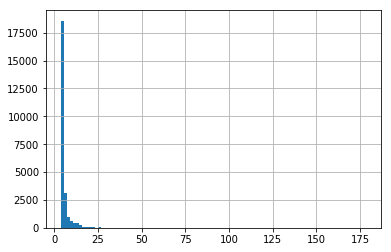

In [6]:
df.사고피해정도.hist(bins=100);

In [7]:
df.사고피해정도.sort_values(ascending=False).head()

7972     178
18779    160
24329    147
5962     140
16738    117
Name: 사고피해정도, dtype: int64

대부분의 사고피해정도는 6이하의 값을 가지고, 쪼금 높은 사고피해정도는 7~25정도 값을 가진다. 100 이상의 사고피해정도가 나타나는 사고들도 몇건 존재한다. 그리고 가장 피해가 심한 사고의 사고피해정도는 178정도로 나타난다.        
                 
사고피해정도가 100이상인 사고 몇건을 살펴보기.

In [8]:
df[df.사고피해정도>=100]

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,총부상자수,사고피해정도
2564,2016,2016110609,30,주간,일,4,44,22,17,1,대전,대덕구,차대차,기타,기타,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,중형,승합차,대형,992831,1823258,127.420045,36.406800,40,117
3891,2016,2016071717,55,주간,일,4,43,13,26,0,강원,평창군,차대차,추돌,진행중 추돌,운전자법규위반,안전운전 의무 불이행,단일로,터널안,승합차,대형,승용차,중형,1078903,1953071,128.393537,37.573637,39,107
5962,2016,2016010109,45,주간,금,1,67,4,62,0,전남,곡성군,차대차,추돌,진행중 추돌,운전자법규위반,안전거리 미확보,단일로,기타단일로,승합차,대형,승합차,대형,973572,1692938,127.220318,35.227824,66,140
7287,2015,2015092318,41,야간,수,2,51,21,17,11,서울,강서구,차대차,추돌,진행중 추돌,운전자법규위반,신호위반,교차로,교차로내,승합차,대형,승합차,대형,939638,1951489,126.816545,37.560781,49,116
7972,2015,2015073117,50,주간,금,2,60,54,4,0,경남,거제시,차량단독,공작물충돌,공작물충돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,없음,없음,1097971,1656401,128.572280,34.897637,58,178
15216,2013,2013121806,41,주간,수,4,36,25,7,0,강원,강릉시,차대차,추돌,주정차중 추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,승합차,대형,1127916,1966566,128.950816,37.689729,32,105
15746,2013,2013111011,30,주간,일,1,43,14,28,0,충남,천안시,차대차,추돌,진행중 추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,승합차,대형,970483,1866208,127.169152,36.793562,42,102
16738,2013,2013090509,19,주간,목,1,47,28,11,7,인천,부평구,차대차,추돌,주정차중 추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,화물차,소형,934111,1941810,126.754838,37.473166,46,117
18779,2013,2013033120,5,야간,일,1,57,45,10,1,전북,무주군,차대차,기타,기타,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,승합차,대형,1007192,1780399,127.579819,36.020400,56,160
21010,2012,2012101721,15,야간,수,3,35,26,6,0,대구,동구,차대차,측면직각충돌,측면직각충돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,대형,승용차,중형,1110714,1765032,128.726461,35.875616,32,102


- 사고피해정도가 100 이상으로 피해가 심한 사고들은 모두 1당이던 2당이던 항상 승합차가 포함돼있다.
- 1건 빼고 모두 단일로에서 발생했다.
- 주간이 8건, 야간이 3건으로 주간에 훨씬 많이 발생했다.

# 사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수 분포 확인

우리 주변에 사망교통사고가 많이 안일어나기도 하고, 일어난다 하더라도 큰 규모의 사고는 잘 일어나지 않습니다. 이에 우리가 예측해야하는 사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수들은 어느정도 범위 안의 수치가 대부분이고, 그 이외의 수치는 잘 나타나지 않을 것이라고 생각. 

In [9]:
n = df.shape[0]

a = [(df.부상신고자수==0).sum()/n, (df.부상신고자수==1).sum()/n, (df.부상신고자수==2).sum()/n, (df.부상신고자수==3).sum()/n,(df.부상신고자수>=4).sum()/n ]
b = [(df.경상자수==0).sum()/n, (df.경상자수==1).sum()/n, (df.경상자수==2).sum()/n, (df.경상자수==3).sum()/n,(df.경상자수>=4).sum()/n ]
c = [(df.중상자수==0).sum()/n, (df.중상자수==1).sum()/n, (df.중상자수==2).sum()/n, (df.중상자수==3).sum()/n,(df.중상자수>=4).sum()/n ] 
d = [(df.총부상자수==0).sum()/n, (df.총부상자수==1).sum()/n, (df.총부상자수==2).sum()/n, (df.총부상자수==3).sum()/n,(df.총부상자수>=4).sum()/n ]
e = [(df.사망자수==0).sum()/n, (df.사망자수==1).sum()/n, (df.사망자수==2).sum()/n, (df.사망자수==3).sum()/n,(df.사망자수>=4).sum()/n ]
f = [(df.사상자수==0).sum()/n, (df.사상자수==1).sum()/n, (df.사상자수==2).sum()/n, (df.사상자수==3).sum()/n,(df.사상자수>=4).sum()/n ]


temp = { '부상자수비율':a,
         '경상자수비율':b,
         '중상자수비율':c,
         '총부상자수비율':d,
         '사망자수비율':e,
         '사상자수비율':f}

df_hurt = pd.DataFrame(temp, index=['0','1','2','3','4명이상'])

df_hurt

,부상자수비율,경상자수비율,중상자수비율,총부상자수비율,사망자수비율,사상자수비율
0,0.982386,0.871430,0.831729,0.748612,0.000000,0.000000
1,0.014099,0.083237,0.107761,0.137636,0.966809,0.736150
2,0.001717,0.023246,0.033431,0.053002,0.028198,0.141271
3,0.000679,0.009786,0.013500,0.025522,0.003195,0.055518
4명이상,0.001118,0.012302,0.013580,0.035228,0.001797,0.067061


- 사망자수: 사망자수가 0인 데이터는 없습니다. 즉 모든 교통사고가 아닌, 사망자수가 1명 이상인 교통사망사고데이터입니다.사망자수가 1명인 데이터가 96%로 대부분을 차지하고, 2명인 데이터는 3프로정도, 3명이상인 데이터는 0.5프로정도로 거의 없습니다.

- 중상자수: 중상자수가 0명인 데이터가 83%로 대부분을 차지하고, 1명인 데이터가 10%정도, 2명인 데이터가 3%정도, 3명이상인 데이터는 2%정도로 거의 없습니다.

- 경상자수: 경상자수가 0명인 데이터가 87%로 대부분을 차지하고, 1명인 데이터가 8%정도, 2명인 데이터가 2%정도, 3명이사인 데이터가 2%정도로 거의 없습니다.

- 부상신고자수비율: 부상신고자가0명인 데이터가 98%정도로 대부분을 차지하고, 1명 이상인 데이터가 2%정도로 거의 없습니다.

사망자수는 대부분 1~2, 중상자수, 경상자수는 대부분 0~3, 부상신고자수는 대부분0~1명 값을 가지기에 모델로 예측을 할 때 오차범위가 그리 크지 않을 것이라고 생각합니다. 이때 우리에게 문제가 되는 경우는, 특이하게 피해자수가 높게 나타나는 사고들을 찾아내지 못해 낮은 수치로 예상하는 경우입니다. 따라서 피해자수가 특이하게 높게 나타나는 사고들의 특징을 잘 파악하여 이를 잡아낼 수 있는 변수를 추가시키는 일이 중요하다고 생각합니다.